# Raghav's Viz Code

In [19]:
import cv2
import matplotlib.pyplot as plt
import os

In [20]:
def load_disparity(orig_base_path, disp_dir, pairing, capture_id, image_code):
    orig_path = os.path.join(
        orig_base_path,
        "rectified",
        pairing[0],
        "Video_data",
        capture_id,
        f"image_{image_code:03}.jpg",
    )
    disp_path = os.path.join(
        disp_dir,
        f"cfnet_disp_{pairing[0]}_{pairing[1]}",
        capture_id,
        f"image_{image_code:03}.pfm",
    )
    disp = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED)
    im = cv2.imread(orig_path)
    if disp is None or type(im) is None:
        return
    print(disp.shape, im.shape)
    plt.figure(figsize=(16, 9))
    plt.subplot(121)
    plt.imshow(im[:, :, ::-1])
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(disp)
    plt.colorbar()
    plt.axis("off")
    plt.title(f"image_{image_code:03d}")
    plt.show()


Capture ID: 20230212_131026_246
(800, 600) (800, 600, 3)


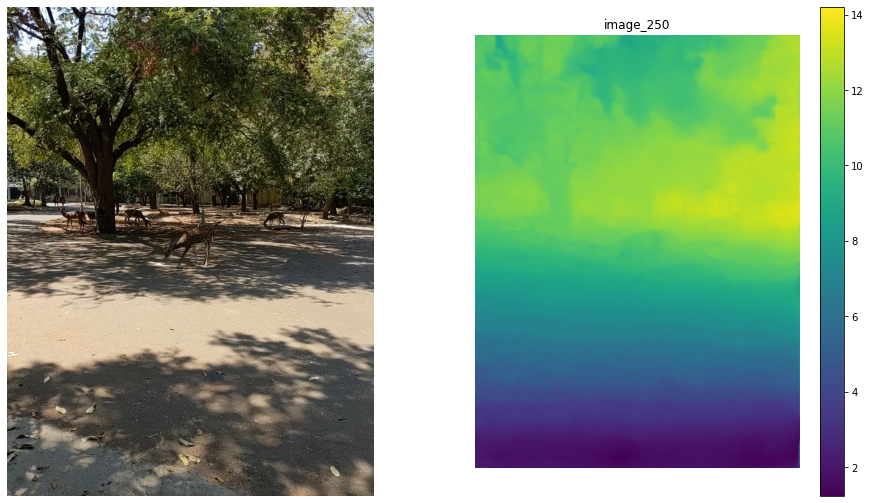

(800, 600) (800, 600, 3)


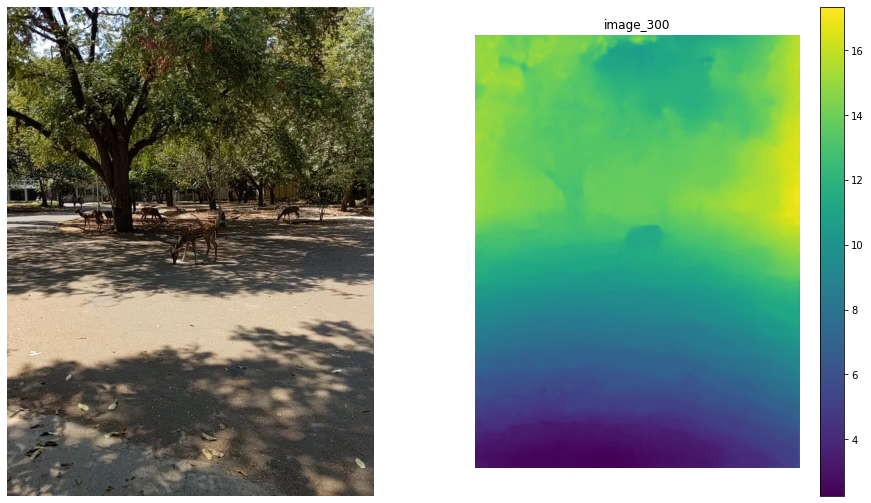

(800, 600) (800, 600, 3)


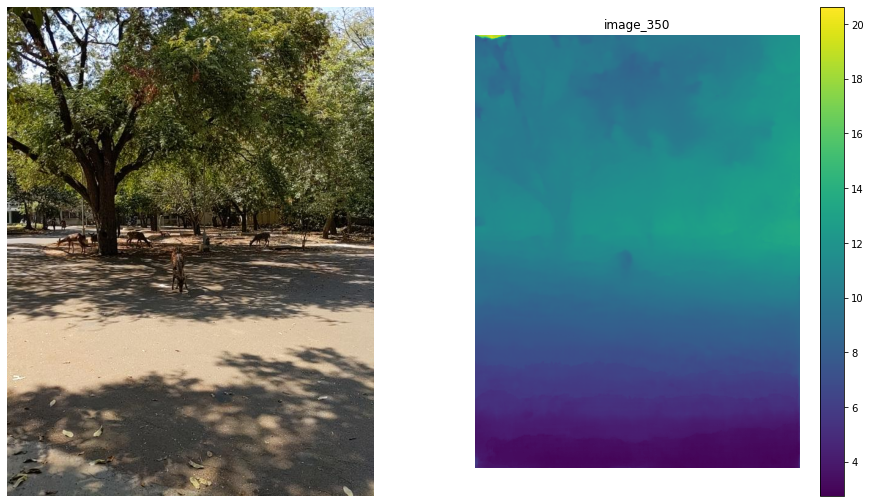

(800, 600) (800, 600, 3)


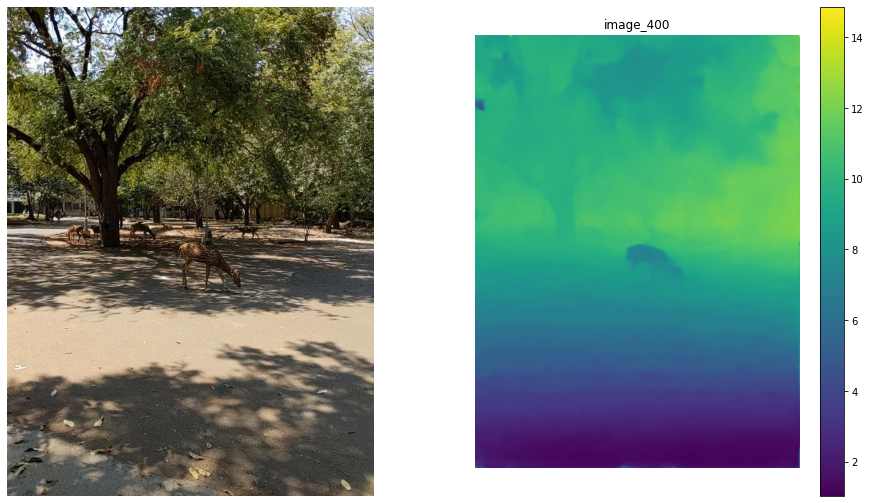

In [21]:
orig_base_path = "/data2/raghav/datasets/Pixel4_3DP"
disp_dir = "/data2/raghav/datasets/Pixel4_3DP/rectified/B"
pairing = ["B", "A"]
for capture_id in sorted(
    os.listdir(os.path.join(disp_dir, f"cfnet_disp_{pairing[0]}_{pairing[1]}"))
):
    print(f"Capture ID: {capture_id}")
    for im_code in range(50, 451, 50):
        load_disparity(
            image_code=im_code,
            orig_base_path=orig_base_path,
            pairing=pairing,
            capture_id=capture_id,
            disp_dir=disp_dir,
        )
    break


# Aryan's Viz Code

### Single Frame Viz

In [22]:
# old, do not run
# capture_id = '20230301_170913_762'
# pairing = ['B', 'A']
# im_code = 150
# load_disparity(
#     disp_path=f'/data2/raghav/datasets/Pixel4_3DP/disp_{pairing[0]}_{pairing[1]}/{capture_id}/image_{im_code:03}.pfm',
#     orig_path=f'/data2/raghav/datasets/Pixel4_3DP/rectified/{pairing[0]}/Video_data/{capture_id}/image_{im_code:03}.jpg'
import numpy as np
import cv2
import matplotlib.pyplot as plt

# disp_path_igev = "./pixel4_subset/igev_disp_400deer/B_rect_image_400.npy"
disp_path = "ACVNet/disp_output/left_20230320_160252_618_image_026.npy"
im_path = "pixel4_subset/cagedBarrel/left_20230320_160252_618_image_026.jpg"

disp = np.load(disp_path, allow_pickle=True)
# disp = cv2.normalize(disp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)

# print(disp.shape, im.shape)
# print(disp.dtype, im.dtype)
# print(disp.max(), disp.min())

if disp is None or type(im) is None:
    print(f"[!] disp or im is None")
else:
    print(disp.shape, im.shape)
    plt.figure(figsize=(16, 9))
    plt.subplot(121)
    plt.imshow(im[:, :, ::-1])
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(disp.squeeze(axis=2))
    plt.colorbar()
    plt.axis("off")
    plt.suptitle(f"ACVNet: {disp_path.split('/')[-1]} | disp: {disp.dtype} max: {disp.max():.3f} min: {disp.min():.3f}")
    # plt.show()
    plt.savefig(f"{im_path.split('/')[-1]}", bbox_inches='tight', pad_inches=0.1)

FileNotFoundError: [Errno 2] No such file or directory: 'ACVNet/disp_output/left_20230320_160252_618_image_026.npy'

### Animation Viz

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import cv2 
from IPython import display

In [ ]:
disp_path = "unimatch/output/pixel4/insideMainGate_wild/"
im_path = "pixel4_subset/insideMainGate/B_mainGate/"

# print(sorted(os.listdir(disp_path)))
# disp_imgs = [np.load(disp_path+fileNam, allow_pickle=True) for fileNam in sorted(os.listdir(disp_path))]
disp_imgs = [cv2.imread(disp_path+fileNam, cv2.IMREAD_UNCHANGED) for fileNam in sorted(os.listdir(disp_path))]
imgs = [cv2.imread(im_path+fileNam, cv2.IMREAD_UNCHANGED) for fileNam in sorted(os.listdir(im_path))]


FileNotFoundError: [Errno 2] No such file or directory: 'unimatch/output/pixel4/insideMainGate_wild/'

NameError: name 'imgs' is not defined

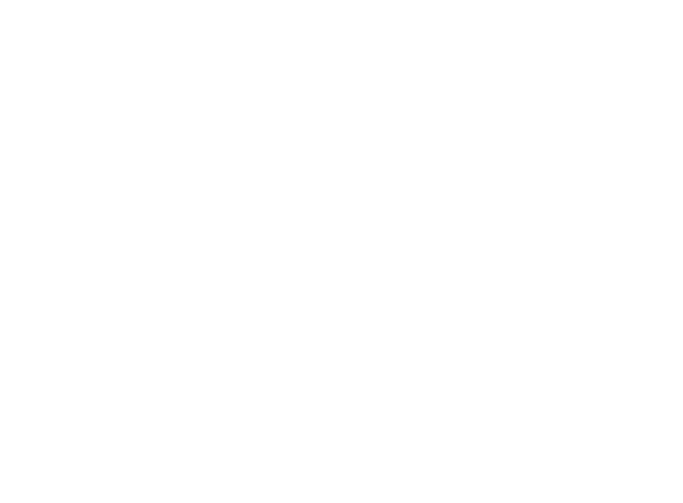

In [ ]:
def update(frame):
    img1.set_array(imgs[frame])
    img2.set_array(disp_imgs[frame])
    return img1, img2


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
ax1.axis('off')
ax2.axis('off')
img1 = ax1.imshow(imgs[0])
img2 = ax2.imshow(disp_imgs[0])

anim = animation.FuncAnimation(fig, update, frames=min(len(disp_imgs),1000), interval=100, blit=True)

anim.save('unimatch_insideMainGate.mp4')

plt.close()
display.HTML(anim.to_jshtml())

# Notebook DataLoader 

In [2]:
import os

from datetime import datetime as dt
import json
import numpy as np
import random
from tqdm import tqdm, trange
import time
import matplotlib.pyplot as plt
import seaborn as sns

### Torch imports ###
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.distributed
from tensorboardX import SummaryWriter
import torchvision
from utils import RunningAverage, denormalize3d, denormalize1d

In [3]:
### Custom imports ###
import model_io
from dataloader import LFDataLoader

In [4]:
class ARGS:
    train_height = 256
    train_width = 192 
    batchsize = 100
    workers = 4
    val_height = 512
    val_width = 384
    datapath = "/data2/raghav/datasets/Pixel4_3DP/rectified"
    unrect_datapath = '/data2/raghav/datasets/Pixel4_3DP/unrectified'
    use_unimatch = True
    unimatch_disp_path = './disparity_maps/disp_pixel4_BA'
    filenames_file_folder = "./train_inputs/Pixel4_3DP_frame_skip10"
    visualization_shuffle = True


In [4]:
args_mini = ARGS()

In [5]:
train_loader = LFDataLoader(args_mini, 'train').data
val_loader = LFDataLoader(args_mini, 'eval').data
test_loader = LFDataLoader(args_mini, 'test').data

Train dataset length:  4418
Validation dataset length:  536
Test dataset length:  617


In [11]:
4418+536+617, 4418*100./(4418+536+617), 536*100./(4418+536+617), 617*100./(4418+536+617)

(5571, 79.30353616944893, 9.621252916891043, 11.075210913660024)

In [6]:
id2typeDict = {0: 'train', 1: 'val', 2: 'test'}
id2typeDict

{0: 'train', 1: 'val', 2: 'test'}

In [9]:
# for id_, dl in enumerate([train_loader, val_loader, test_loader]):
#     for i, batch in enumerate(dl):
#         # max_disp = random.choice([0.6, 0.9, 1.2, 1.5])
#         # zero_plane = random.uniform(0.2, 0.4)
#         # left_pd = batch['left_pd']
#         # print(left_pd.shape)
#         # left_pd_dark = torch.zeros_like(left_pd)
#         # print(left_pd_dark.shape)
#         imgs = denormalize3d(batch['center'])
#         disps = denormalize1d(batch['disp'])
#         scaled_disps = torch.abs(disps)

#         grid = torchvision.utils.make_grid(imgs, nrow=10).permute(1, 2, 0)
#         grid_disp = torchvision.utils.make_grid(scaled_disps, nrow=10).permute(1, 2, 0)

#         fig1 = plt.figure(figsize=(50, 50))
#         fig1.set_tight_layout(True)
#         plt.imshow(grid)
#         plt.title(f"{id2typeDict[id_]}")
#         fig1.savefig(f"Viz_Samples_{id2typeDict[id_]}.jpg")
#         # fig1.close()

#         fig2 = plt.figure(figsize=(50,50))
#         fig2.set_tight_layout(True)
#         plt.imshow(grid_disp)
#         plt.title(f"Scaled Disp: {id2typeDict[id_]}")
#         fig2.savefig(f"Viz_ScDisp_{id2typeDict[id_]}.jpg")
#         # fig2.close()

#         print(f"[+] Saved {id2typeDict[id_]}")
#         break

# Train-Val-Test Video Maker

In [16]:
from moviepy.editor import *

In [10]:
with open("./train_inputs/Pixel4_3DP_frame_skip10/train_files.txt", "r") as f:
    train_files = f.readlines()

with open("./train_inputs/Pixel4_3DP_frame_skip10/test_files.txt", "r") as f:
    test_files = f.readlines()

with open("./train_inputs/Pixel4_3DP_frame_skip10/val_files.txt", "r") as f:
    val_files = f.readlines()

len(train_files), len(test_files), len(val_files)

(4418, 617, 536)

In [18]:
args = ARGS()

In [19]:
def keep_only_rgb(x_files):
    for i in range(len(x_files)):
        x_files[i] = x_files[i].split(';')[0]
        x_files[i] = os.path.join(args.datapath, "B", "Video_data", x_files[i])
    return x_files

train_files = keep_only_rgb(train_files)
test_files = keep_only_rgb(test_files)
val_files = keep_only_rgb(val_files)

In [26]:
def get_unique_videos_in(x_files):
    uniq_vids = set()
    for path_ in x_files:
        videoName = path_.split('/')[-2]
        uniq_vids.add(videoName)
    return uniq_vids

trainVids = get_unique_videos_in(train_files)
testVids = get_unique_videos_in(test_files)
valVids = get_unique_videos_in(val_files)

len(trainVids), len(testVids), len(valVids)

(108, 15, 13)

In [20]:
from moviepy.video.VideoClip import ImageClip
from moviepy.video.compositing.CompositeVideoClip import CompositeVideoClip

train_clips = [ImageClip(m).set_duration(1/24) for m in train_files]
val_clips = [ImageClip(m).set_duration(1/24) for m in val_files]
test_clips = [ImageClip(m).set_duration(1/24) for m in test_files]

In [21]:
concat_clip_train = concatenate_videoclips(train_clips, method="compose")
concat_clip_train.write_videofile("train_vid.mp4", fps=24)

concat_clip_train = concatenate_videoclips(val_clips, method="compose")
concat_clip_train.write_videofile("val_vid.mp4", fps=24)

concat_clip_train = concatenate_videoclips(test_clips, method="compose")
concat_clip_train.write_videofile("test_vid.mp4", fps=24)

Moviepy - Building video train_vid.mp4.
Moviepy - Writing video train_vid.mp4



Moviepy - Done !
Moviepy - video ready train_vid.mp4
Moviepy - Building video val_vid.mp4.
Moviepy - Writing video val_vid.mp4



Moviepy - Done !
Moviepy - video ready val_vid.mp4
Moviepy - Building video test_vid.mp4.
Moviepy - Writing video test_vid.mp4



Moviepy - Done !
Moviepy - video ready test_vid.mp4
